# Evaluation of Different Embeddings

This notebook demonstrates the evaluation of embeddings achieved by Wasserstein and Kullback-Leibler divergence. The evaluations have 2 parts:

- Spearman rank correlation score on several human-annotated datasets, such as WordSim-353, etc.
- Visualization of Wasserstein `word2cloud`

# Word Similarity Bencmark

## Load packages and data

In [1]:
import pickle

import numpy as np
import pandas as pd

In [2]:
from utils import *
from kl_net import *
from wass_net import *

In [3]:
def read_ground_truth(file):
    """ Reads word pairs and human-annotated similarities from local files.
    """
    ground_truth = pd.read_csv(file)
    word_pairs = list(zip(ground_truth['Word 1'], ground_truth['Word 2']))
    sim = list(ground_truth['Human (mean)'].values)

    return word_pairs, sim

def spearman_rank_correlation(true_sim, pred_sim):
    """ Computes the Spearman rank correlaion.
    """
    assert true_sim.shape[0] == pred_sim.shape[0], 'number of true similarity ({}) not equal to number of predicted similarity ({})!'.format(true_sim.shape[0], pred_sim.shape[0])
    n = true_sim.shape[0]

    true_rank_idx = np.argsort(true_sim)[::-1]
    true_rank = np.arange(true_sim.shape[0])
    true_rank[true_rank_idx] = np.arange(true_sim.shape[0])

    pred_rank_idx = np.argsort(pred_sim)
    pred_rank = np.arange(pred_sim.shape[0])
    pred_rank[pred_rank_idx] = np.arange(pred_sim.shape[0])

    r = 1 - 6 * np.sum((true_rank - pred_rank) ** 2) / (n * (n*n - 1))
    return r

load vocabulary list and vocab2id dictionary

In [4]:
with open('./data/vocab2id.pkl', 'rb') as infile:
    vocab2id = pickle.load(infile)
with open('./data/vocab.pkl', 'rb') as infile:
    vocab = pickle.load(infile)

load annotated datasets

In [5]:
datasets = ['RG-65', 'WS-353', 'MC-30', 'Rare-Word', 'MEN', 'MTurk-287', 'SimLex-999']

In [6]:
rg_word_pairs, rg_sim = read_ground_truth('./benchmark/RG-65.csv')
ws_word_pairs, ws_sim = read_ground_truth('./benchmark/wordsim353.csv')
mc_word_pairs, mc_sim = read_ground_truth('./benchmark/MC.csv')
rw_word_pairs, rw_sim = read_ground_truth('./benchmark/RW.csv')
men_word_pairs, men_sim = read_ground_truth('./benchmark/MEN-LEM.csv')
turk_word_pairs, turn_sim = read_ground_truth('./benchmark/TRUK.csv')
lex_word_pairs, lex_sim = read_ground_truth('./benchmark/SIM999.csv')

word_pairs = [rg_word_pairs, ws_word_pairs, mc_word_pairs, rw_word_pairs, men_word_pairs, turk_word_pairs, lex_word_pairs]
similarities = [rg_sim, ws_sim, mc_sim, rw_sim, men_sim, turn_sim, lex_sim]

## Wasserstien-$\mathbb{R}^4$-16

load trained embedding

In [7]:
embeddings = np.load('./results/WikiSmall_WassR4_16_batch.npz')['embeddings']
embed_dim = 16
ground_dim = 4

compute Spearman scores on different datasets

In [8]:
results = pd.DataFrame(index=datasets, columns=['# word pairs', '# recognized pairs', 'Spearman Correlation'])

In [9]:
for wp, sims, name in zip(word_pairs, similarities, datasets):
    print("Dataset: {}".format(name))
    n_wps = len(wp)
    recognized = [[vocab2id.get(w1), vocab2id.get(w2), sim] for (w1, w2), sim in zip(wp, sims)]
    recognized = [[w1, w2, sim] for w1, w2, sim in recognized if w1 is not None and w2 is not None]
    n_recognized = len(recognized)
    recog_wp = np.array([[w1, w2] for w1, w2, _ in recognized])
    true_sim = np.array([sim for _, _, sim in recognized])
    pred_sim = predict_wass(recog_wp, embeddings, dim=embed_dim, ground_dim=ground_dim, lambd=0.5)
    score = spearman_rank_correlation(true_sim, pred_sim)
    results.loc[name, :] = [n_wps, n_recognized, score]

Dataset: RG-65
Dataset: WS-353
Dataset: MC-30
Dataset: Rare-Word
Dataset: MEN
Dataset: MTurk-287
Dataset: SimLex-999


In [10]:
results

,# word pairs,# recognized pairs,Spearman Correlation
RG-65,65,16,-0.217647
WS-353,353,225,-0.0886884
MC-30,30,11,-0.290909
Rare-Word,2034,72,0.185671
MEN,3000,1144,-0.000709913
MTurk-287,287,103,-0.183532
SimLex-999,999,478,-0.0060289


## Wasserstien-$\mathbb{R}^2$-32

load trained embedding

In [11]:
embeddings = np.load('./results/WikiSmall_WassR2_32_batch.npz')['embeddings']
embed_dim = 32
ground_dim = 2

compute Spearman scores on different datasets

In [12]:
results = pd.DataFrame(index=datasets, columns=['# word pairs', '# recognized pairs', 'Spearman Correlation'])

In [13]:
for wp, sims, name in zip(word_pairs, similarities, datasets):
    print("Dataset: {}".format(name))
    n_wps = len(wp)
    recognized = [[vocab2id.get(w1), vocab2id.get(w2), sim] for (w1, w2), sim in zip(wp, sims)]
    recognized = [[w1, w2, sim] for w1, w2, sim in recognized if w1 is not None and w2 is not None]
    n_recognized = len(recognized)
    recog_wp = np.array([[w1, w2] for w1, w2, _ in recognized])
    true_sim = np.array([sim for _, _, sim in recognized])
    pred_sim = predict_wass(recog_wp, embeddings, dim=embed_dim, ground_dim=ground_dim, lambd=0.5)
    score = spearman_rank_correlation(true_sim, pred_sim)
    results.loc[name, :] = [n_wps, n_recognized, score]

Dataset: RG-65
Dataset: WS-353
Dataset: MC-30
Dataset: Rare-Word
Dataset: MEN
Dataset: MTurk-287
Dataset: SimLex-999


In [14]:
results

,# word pairs,# recognized pairs,Spearman Correlation
RG-65,65,16,0.447059
WS-353,353,225,0.279336
MC-30,30,11,0.227273
Rare-Word,2034,72,-0.00784616
MEN,3000,1144,0.290682
MTurk-287,287,103,0.24654
SimLex-999,999,478,0.12247


## KL-32

load trained embedding

In [15]:
embeddings = np.load('./results/WikiSmall_KL_32_batch.npz')['embeddings']
embed_dim = 32

compute Spearman scores on different datasets

In [16]:
results = pd.DataFrame(index=datasets, columns=['# word pairs', '# recognized pairs', 'Spearman Correlation'])

In [17]:
for wp, sims, name in zip(word_pairs, similarities, datasets):
    print("Dataset: {}".format(name))
    n_wps = len(wp)
    recognized = [[vocab2id.get(w1), vocab2id.get(w2), sim] for (w1, w2), sim in zip(wp, sims)]
    recognized = [[w1, w2, sim] for w1, w2, sim in recognized if w1 is not None and w2 is not None]
    n_recognized = len(recognized)
    recog_wp = np.array([[w1, w2] for w1, w2, _ in recognized])
    true_sim = np.array([sim for _, _, sim in recognized])
    pred_sim = predict_kl(recog_wp, embeddings, dim=embed_dim)
    score = spearman_rank_correlation(true_sim, pred_sim)
    results.loc[name, :] = [n_wps, n_recognized, score]

Dataset: RG-65
Dataset: WS-353
Dataset: MC-30
Dataset: Rare-Word
Dataset: MEN
Dataset: MTurk-287
Dataset: SimLex-999


In [18]:
results

,# word pairs,# recognized pairs,Spearman Correlation
RG-65,65,16,0.126471
WS-353,353,225,0.0970196
MC-30,30,11,0.309091
Rare-Word,2034,72,-0.127886
MEN,3000,1144,0.0379169
MTurk-287,287,103,0.0742213
SimLex-999,999,478,0.060071


## KL-64

load trained embedding

In [19]:
embeddings = np.load('./results/WikiSmall_KL_64_batch.npz')['embeddings']
embed_dim = 64

compute Spearman scores on different datasets

In [20]:
results = pd.DataFrame(index=datasets, columns=['# word pairs', '# recognized pairs', 'Spearman Correlation'])

In [21]:
for wp, sims, name in zip(word_pairs, similarities, datasets):
    print("Dataset: {}".format(name))
    n_wps = len(wp)
    recognized = [[vocab2id.get(w1), vocab2id.get(w2), sim] for (w1, w2), sim in zip(wp, sims)]
    recognized = [[w1, w2, sim] for w1, w2, sim in recognized if w1 is not None and w2 is not None]
    n_recognized = len(recognized)
    recog_wp = np.array([[w1, w2] for w1, w2, _ in recognized])
    true_sim = np.array([sim for _, _, sim in recognized])
    pred_sim = predict_kl(recog_wp, embeddings, dim=embed_dim)
    score = spearman_rank_correlation(true_sim, pred_sim)
    results.loc[name, :] = [n_wps, n_recognized, score]

Dataset: RG-65
Dataset: WS-353
Dataset: MC-30
Dataset: Rare-Word
Dataset: MEN
Dataset: MTurk-287
Dataset: SimLex-999


In [22]:
results

,# word pairs,# recognized pairs,Spearman Correlation
RG-65,65,16,0.332353
WS-353,353,225,0.301951
MC-30,30,11,0.272727
Rare-Word,2034,72,0.17104
MEN,3000,1144,0.341648
MTurk-287,287,103,0.338653
SimLex-999,999,478,0.13397


## KL-300

load trained embedding

In [23]:
embeddings = np.load('./results/WikiSmall_KL_300_batch.npz')['embeddings']
embed_dim = 300

compute Spearman scores on different datasets

In [24]:
results = pd.DataFrame(index=datasets, columns=['# word pairs', '# recognized pairs', 'Spearman Correlation'])

In [25]:
for wp, sims, name in zip(word_pairs, similarities, datasets):
    print("Dataset: {}".format(name))
    n_wps = len(wp)
    recognized = [[vocab2id.get(w1), vocab2id.get(w2), sim] for (w1, w2), sim in zip(wp, sims)]
    recognized = [[w1, w2, sim] for w1, w2, sim in recognized if w1 is not None and w2 is not None]
    n_recognized = len(recognized)
    recog_wp = np.array([[w1, w2] for w1, w2, _ in recognized])
    true_sim = np.array([sim for _, _, sim in recognized])
    pred_sim = predict_kl(recog_wp, embeddings, dim=embed_dim)
    score = spearman_rank_correlation(true_sim, pred_sim)
    results.loc[name, :] = [n_wps, n_recognized, score]

Dataset: RG-65
Dataset: WS-353
Dataset: MC-30
Dataset: Rare-Word
Dataset: MEN
Dataset: MTurk-287
Dataset: SimLex-999


In [26]:
results

,# word pairs,# recognized pairs,Spearman Correlation
RG-65,65,16,0.679412
WS-353,353,225,0.387135
MC-30,30,11,0.745455
Rare-Word,2034,72,0.311692
MEN,3000,1144,0.314799
MTurk-287,287,103,0.257765
SimLex-999,999,478,0.0680412


# Visualizaion of Wasserstein `word2cloud`

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [28]:
embeddings = np.load('./results/WikiSmall_WassR2_32_batch.npz')['embeddings']

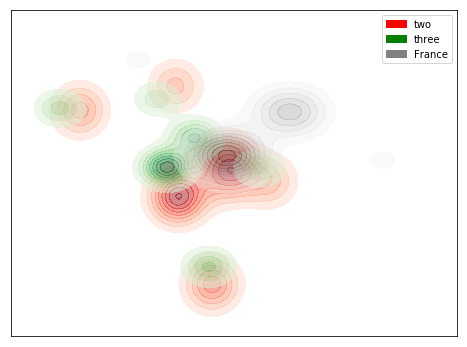

In [29]:
word1 = "two"
wid1 = vocab2id[word1]
embedding1 = embeddings[wid1]
embedding1 = np.reshape(embedding1, (-1, 2))

word2 = "three"
wid2 = vocab2id[word2]
embedding2 = embeddings[wid2]
embedding2 = np.reshape(embedding2, (-1, 2))

word3 = "France"
wid3 = vocab2id[word3]
embedding3 = embeddings[wid3]
embedding3 = np.reshape(embedding3, (-1, 2))

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.kdeplot(embedding1[:, 0], embedding1[:, 1], cmap="Reds", shade=True, shade_lowest=False, alpha=0.5, label=word1, color='red')
ax = sns.kdeplot(embedding2[:, 0], embedding2[:, 1], cmap="Greens", shade=True, shade_lowest=False, alpha=0.5, label=word2, color='green')
ax = sns.kdeplot(embedding3[:, 0], embedding3[:, 1], cmap="Greys", shade=True, shade_lowest=False, alpha=0.3, label=word3, color='grey')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend()

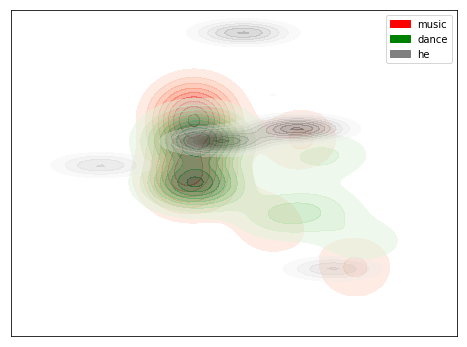

In [30]:
word1 = "music"
wid1 = vocab2id[word1]
embedding1 = embeddings[wid1]
embedding1 = np.reshape(embedding1, (-1, 2))

word2 = "dance"
wid2 = vocab2id[word2]
embedding2 = embeddings[wid2]
embedding2 = np.reshape(embedding2, (-1, 2))

word3 = "he"
wid3 = vocab2id[word3]
embedding3 = embeddings[wid3]
embedding3 = np.reshape(embedding3, (-1, 2))

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.kdeplot(embedding1[:, 0], embedding1[:, 1], cmap="Reds", shade=True, shade_lowest=False, alpha=0.5, label=word1, color='red')
ax = sns.kdeplot(embedding2[:, 0], embedding2[:, 1], cmap="Greens", shade=True, shade_lowest=False, alpha=0.5, label=word2, color='green')
ax = sns.kdeplot(embedding3[:, 0], embedding3[:, 1], cmap="Greys", shade=True, shade_lowest=False, alpha=0.3, label=word3, color='grey')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend()

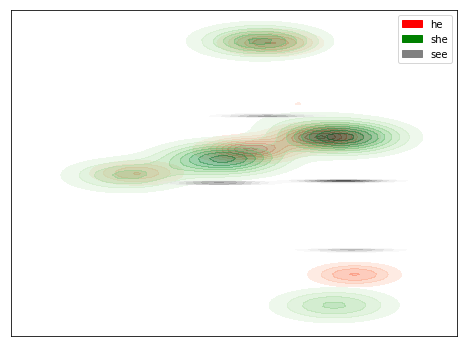

In [31]:
word1 = "he"
wid1 = vocab2id[word1]
embedding1 = embeddings[wid1]
embedding1 = np.reshape(embedding1, (-1, 2))

word2 = "she"
wid2 = vocab2id[word2]
embedding2 = embeddings[wid2]
embedding2 = np.reshape(embedding2, (-1, 2))

word3 = "see"
wid3 = vocab2id[word3]
embedding3 = embeddings[wid3]
embedding3 = np.reshape(embedding3, (-1, 2))

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.kdeplot(embedding1[:, 0], embedding1[:, 1], cmap="Reds", shade=True, shade_lowest=False, alpha=0.5, label=word1, color='red')
ax = sns.kdeplot(embedding2[:, 0], embedding2[:, 1], cmap="Greens", shade=True, shade_lowest=False, alpha=0.5, label=word2, color='green')
ax = sns.kdeplot(embedding3[:, 0], embedding3[:, 1], cmap="Greys", shade=True, shade_lowest=False, alpha=0.3, label=word3, color='grey')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend()

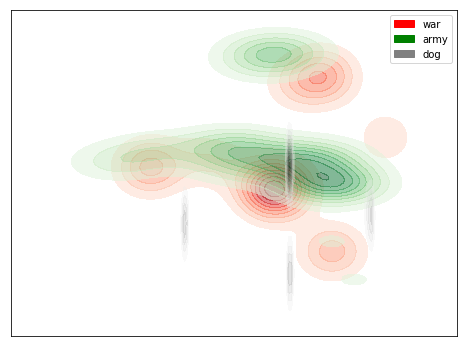

In [32]:
word1 = "war"
wid1 = vocab2id[word1]
embedding1 = embeddings[wid1]
embedding1 = np.reshape(embedding1, (-1, 2))

word2 = "army"
wid2 = vocab2id[word2]
embedding2 = embeddings[wid2]
embedding2 = np.reshape(embedding2, (-1, 2))

word3 = "dog"
wid3 = vocab2id[word3]
embedding3 = embeddings[wid3]
embedding3 = np.reshape(embedding3, (-1, 2))

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.kdeplot(embedding1[:, 0], embedding1[:, 1], cmap="Reds", shade=True, shade_lowest=False, alpha=0.5, label=word1, color='red')
ax = sns.kdeplot(embedding2[:, 0], embedding2[:, 1], cmap="Greens", shade=True, shade_lowest=False, alpha=0.5, label=word2, color='green')
ax = sns.kdeplot(embedding3[:, 0], embedding3[:, 1], cmap="Greys", shade=True, shade_lowest=False, alpha=0.3, label=word3, color='grey')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend()